In [ ]:
from matplotlib import pyplot as plt
import cv2
from skimage.feature import canny
import numpy as np
from scipy import signal
from skimage.measure import regionprops
from scipy.ndimage import label, binary_fill_holes, binary_erosion, gaussian_filter, median_filter, shift, generate_binary_structure, binary_dilation
from patchify import patchify, unpatchify
from torchvision import models, transforms
import torch
from PIL import Image
from skimage.metrics import structural_similarity


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
normalize = lambda im: (im - np.mean(im))/np.std(im)
normalize_zero_one = lambda im: (im - np.min(im)) / (np.max(im)- np.min(im))
tif_to_gray = lambda im: 0.299*im[...,0] + 0.587*im[...,1] + 0.114*im[...,2]

In [ ]:
def align_images(im1, im2):
  im1_gray = normalize(cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY))
  im2_gray = normalize(cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY))
  bounds = np.array(im1_gray.shape[:2])//4
  template = im1_gray[bounds[0]:-bounds[0],bounds[1]:-bounds[1]]
  corr = signal.correlate2d(im2_gray, template, boundary='symm', mode='same')
  y, x = np.unravel_index(np.argmax(corr), corr.shape)
  shift_y, shift_x = y - im1.shape[0]//2, x - im1.shape[1]//2
  im1_shifted = shift(im1, (shift_y, shift_x, 0))
  if shift_y > 0:
    im2[:shift_y,:,:] = 0
  else:
    im2[shift_y:,:,:] = 0
  if shift_x > 0:
    im2[:,:shift_x,:] = 0
  else:
    im2[:,shift_x:,:] = 0
  return im1_shifted, im2

In [ ]:
def generate_vgg_features_maps(image, transform):
  vgg = models.vgg19(True)
  vgg.eval()
  model = list(vgg.children())[0]
  layers = []
  output_idx = []
  for i, layer in enumerate(list(model.children())):
    layers.append(layer)
    if type(layer) == torch.nn.modules.conv.Conv2d:
      output_idx.append(i)

  image = transform(Image.fromarray(image))
  image = image.unsqueeze(0)

  outputs = []
  names = []
  for i, layer in enumerate(layers):
      image = layer(image)
      # print("shape in vgg ", image.shape)
      if i in output_idx:
        feature_map = image.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        outputs.append(gray_scale.detach().numpy())
  return outputs


In [ ]:
def sum_layer(layers_arr, size=None):
  res = layers_arr[0]
  for i in range(1,len(layers_arr)):
    res += layers_arr[i]
  if size is not None:
    res = np.array(Image.fromarray(res).resize(size, Image.NEAREST))
  return res

In [ ]:
def get_all_sumed_layers(features, layer_idx, size=None):
  sum_features = []
  for i in range(len(layer_idx)-1):
    sum_features.append(sum_layer(features[layer_idx[i]:layer_idx[i+1]], size=size))
  return sum_features

In [ ]:
def concatenate_layers(features, layer_idx):
  conct_features = []
  for i in range(len(layer_idx)-1):
    arr = np.array(features[layer_idx[i]:layer_idx[i+1]])
    conct_features.append(arr)
  return conct_features

In [ ]:
def resize_layers(features):
  m = torch.nn.Upsample(mode='nearest')
  prev = None
  for i in range(len(features)):
    f = features[i]
    cur = np.concatenate((f, prev)) if prev is not None else f
    m.size = features[i+1].shape[1:] if i < len(features) - 1 else f.shape
    f_tensor = torch.from_numpy(np.array(cur)).unsqueeze(0)
    if i == len(features) - 1:
      return f_tensor.squeeze(0).numpy()
    cur = m(f_tensor).squeeze(0).numpy()
    prev = cur


In [ ]:
def get_threshold_map(feature_arr, num_std):
  thresh = np.zeros_like(feature_arr)
  white = np.where(feature_arr > np.mean(feature_arr) + num_std*np.std(feature_arr))
  thresh[white] = 1
  return thresh

In [ ]:
def get_regions(layer, sigma):
  add = np.zeros_like(layer[0])
  for i in range(len(layer)):
    add = np.logical_or(add, layer[i])
  return gaussian_filter(add,sigma)  

In [ ]:
def prepare_features(img, transform, layers_idx):
  features = generate_vgg_features_maps(img, transform)
  features = concatenate_layers(features,layer_idx)
  return resize_layers(features[::-1])

In [ ]:
def create_labels_im(img1, img2, sigma):
  im1_norm = normalize(tif_to_gray(img1))
  im2_norm = normalize(tif_to_gray(img2))
  im_labels = get_threshold_map((im1_norm - im2_norm)**2, sigma)
  return im_labels

In [ ]:
def find_regions(im_inspected, im_reference, transform, layers_idx, sigma):
  features_arr1 = prepare_features(im_inspected, transform, layers_idx)
  features_arr2 = prepare_features(im_reference, transform, layers_idx)
  diff = np.array([(features_arr1[i] - features_arr2[i])**2 for i in range(len(features_arr1))])
  ssim = np.array([structural_similarity(features_arr1[i], features_arr2[i], win_size=3, full=True)[1] for i in range(len(features_arr1))])
  ssim = 1 - ssim
  tot = np.zeros_like(diff[0])
  last_layer = np.zeros_like(diff[0])
  for f in range(len(diff)):
    if f > 13:
      ssim_layer = get_threshold_map(ssim[f], sigma/2)
      ssim_layer = binary_erosion(binary_fill_holes(ssim_layer))
      last_layer = np.logical_or(last_layer, ssim_layer)
    thresh_layer = get_threshold_map(diff[f], sigma)
    tot = np.logical_or(tot, thresh_layer)
  if len(np.where(last_layer)[0]) == 0:
    return last_layer, last_layer
  return tot,last_layer

In [ ]:
def analyze_regions(raw_regions):
  centers = []
  labels, num_labels = label(raw_regions)
  props = regionprops(labels)
  # print('number of labels ', num_labels)
  for i in range(1,num_labels):
    center = props[i].centroid
    centers.append(np.array(center).astype(np.int16))
  return centers

In [ ]:
def cc_recursive(im, cur, cc, visited):
    visited[cur[0],cur[1]] = 1
    if cur[0] >= len(im) - 1 or cur[1] >= len(im[0]) - 1:
      print('reached boundry ', cur)
      return np.array(cc)
    if im[cur[0], cur[1]] == 1:
        if cur not in cc:
            cc.append(cur)
    else:
        return np.array(cc)
    directions ={(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)}
    neighbours = [(cur[0] + d[0], cur[1] + d[1]) for d in directions]
    neighbours = filter(lambda n: not visited[n[0], n[1]], neighbours)
    for n in neighbours:
        cc_recursive(im, n, cc, visited)
    return np.array(cc)

In [ ]:
def run_on_patchs(im1,im2, transform, layer_idx, sigma):
  size = np.array(im1.shape[:2])
  res = np.zeros(size)
  p_size =  size // 4
  leftover = size % 4
  r_idx = np.arange(0,size[0], p_size[0])
  r_idx[-1] += leftover[0]
  c_idx = np.arange(0,size[1], p_size[1])
  c_idx[-1] += leftover[1]
  for i in range(len(r_idx)-1):
    for j in range(len(c_idx)):
      # print(i,j)
      r1,c1 = r_idx[i], c_idx[j]
      r2 = r_idx[i+1] if i < len(r_idx) - 1 else size[0]
      c2 = c_idx[j+1] if j < len(c_idx) - 1 else size[1]
      p1 = im1[r1:r2,c1:c2,:]
      p2 = im2[r1:r2,c1:c2,:]
      tot, last = find_regions(p1, p2, transform, layer_idx, sigma)
      res[r1:r2,c1:c2] = tot
      # fig, axes = plt.subplots(1,2)
      # axes[0].imshow(res,cmap='gray')
      # axes[0].set_title('total')
      # axes[1].imshow(last,cmap='gray')
      # axes[1].set_title('last')
      # plt.show()
  return res

In [ ]:
path1 = 'drive/MyDrive/datasets/chip/images/defective_examples/case{}_inspected_image.tif'
path2 = 'drive/MyDrive/datasets/chip/images/defective_examples/case{}_reference_image.tif'

In [ ]:
def find_defects(im_index, sigma):
  im1 = cv2.imread(path1.format(im_index))
  im2 = cv2.imread(path2.format(im_index))
  print("aligning...")
  im1, im2 = align_images(im1, im2)
  layer_idx = [0,2,4,8,12,16]
  transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean=0., std=1.) ])
  print("calculating patchwise regions proposal...")
  tot = run_on_patchs(im1, im2, transform,layer_idx, sigma)
  im_labels = create_labels_im(im1,im2,sigma/3)
  defect_im = np.zeros_like(im_labels)
  sect = np.logical_and(tot, im_labels)
  sect_idx = np.array(np.where(sect)).T
  labels, num_labels = label(im_labels)
  print("segmenting...")
  for i in range(num_labels):
    obj = np.array(np.where(labels==i)).T
    is_defect = (obj==sect_idx[:,None]).all(-1).any()
    if is_defect:
      # print(obj.shape)
      defect_im[obj[:,0],obj[:,1]]=1
  plt.imshow(im_labels,cmap='gray')
  plt.title('labels')
  plt.savefig(f"drive/MyDrive/datasets/chip/results/{im_index}_labels")
  plt.show()
  plt.imshow(defect_im,cmap='gray')
  plt.title('defects')
  plt.savefig(f"drive/MyDrive/datasets/chip/results/{im_index}_defects")
  plt.show()
  return defect_im



aligning...
calculating patchwise regions proposal...


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


segmenting...


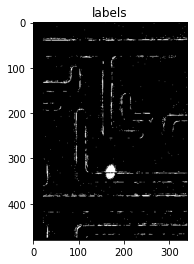

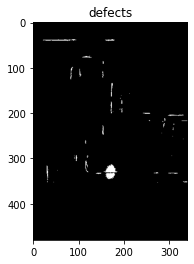

In [ ]:
res = find_defects(1, 6)